In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Will be our dataset!
from palmerpenguins import load_penguins

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Clustering imports
from sklearn.cluster import KMeans

# Classification imports
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, f1_score

# Regression imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

In [2]:
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 1.2.2


## Loading the dataset, and quick EDA

In [3]:
df = load_penguins()
print('data type for penguins', type(df))
print(' ')
df

data type for penguins <class 'pandas.core.frame.DataFrame'>
 


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


<AxesSubplot:>

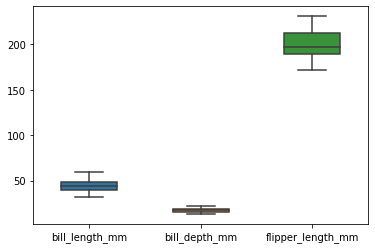

In [5]:
sns.boxplot(data=df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']], width=0.5,fliersize=5)

Correlation:


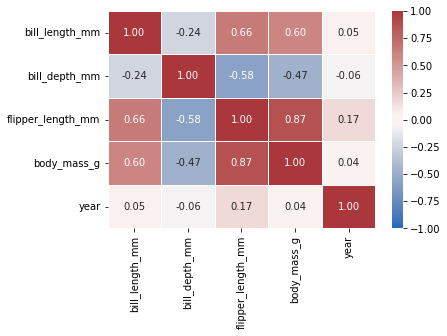

In [6]:
print('Correlation:')
sns.heatmap(df.corr(),
           annot=True,
           fmt=".2f",
           linewidth=.5,
           cmap="vlag",
           vmin=-1, vmax=1);

In [7]:
df[df.species == "Adelie"].year.nunique()

3

Year is not correlated to penguins, so let's drop it!

In [8]:
df = df.drop(['year'], axis=1)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male


We can also get a count of all the nans in the dataset:

In [9]:
df.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [10]:
df = df.dropna() # this drops all rows with a nan in it
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


# Preprocessing

In [11]:
df_scaled = df.copy() # we will scale the numerical columns of this dataset
df_scaled.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [12]:
float_cols = df.select_dtypes(include=[float]).columns.values
float_cols

array(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g'], dtype=object)

In [13]:
scaler = preprocessing.StandardScaler().fit(df[float_cols])

In [14]:
df_scaled.loc[:, float_cols] = scaler.transform(df[float_cols])
df_scaled.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,-0.896042,0.780732,-1.426752,-0.568475,male
1,Adelie,Torgersen,-0.822788,0.119584,-1.069474,-0.506286,female
2,Adelie,Torgersen,-0.676280,0.424729,-0.426373,-1.190361,female


In [15]:
df_scaled.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,3.330000e+02,3.330000e+02,3.330000e+02,3.330000e+02
mean,-1.024206e-15,-1.280257e-15,2.560514e-16,-1.280257e-16
std,1.001505e+00,1.001505e+00,1.001505e+00,1.001505e+00
min,-2.177987e+00,-2.067291e+00,-2.069852e+00,-1.874435e+00
25%,-8.227879e-01,-7.958519e-01,-7.836512e-01,-8.172292e-01
50%,9.288742e-02,6.872642e-02,-2.834620e-01,-1.953432e-01
75%,8.437412e-01,7.807321e-01,8.598276e-01,7.063915e-01
max,2.858227e+00,2.204743e+00,2.146028e+00,2.603144e+00


Lastly, let's shuffle the dataframe rows and re-set the index:

In [16]:
df_scaled = df_scaled.sample(frac=1).reset_index(drop=True)

# Clustering

In [17]:
# Set the number of clusters to use in the KMeans algorithm
num_clusters = 3

# Initialize the KMeans algorithm with the number of clusters, a random state, and n_init parameter
# - n_clusters: number of clusters to form
# - random_state: seed used by the random number generator
# - n_init: Number of time the k-means algorithm will be run with different centroid seeds. 

kmeans = KMeans(n_clusters=num_clusters, 
                random_state=3, 
                n_init="auto").fit(df_scaled[float_cols])

In [18]:
df_scaled['kmeans'] = kmeans.labels_
df_scaled

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,kmeans
0,Adelie,Torgersen,-0.163502,1.035020,-0.283462,-0.879418,male,2
1,Chinstrap,Dream,1.063503,0.068726,-0.212006,-0.661758,female,0
2,Adelie,Dream,-0.529772,0.475587,0.288183,0.115600,male,2
3,Adelie,Torgersen,-0.694593,-0.083846,-1.784030,-0.941606,female,2
4,Adelie,Biscoe,-1.482074,1.035020,-0.855107,-0.506286,female,2
...,...,...,...,...,...,...,...,...
328,Adelie,Dream,-0.145188,0.679017,-0.640740,-0.133155,male,2
329,Adelie,Dream,-1.317253,0.679017,-0.569284,-0.879418,female,2
330,Chinstrap,Dream,-0.145188,-0.287276,-0.998018,-1.625681,female,2
331,Adelie,Torgersen,-0.621339,0.933305,-0.140551,-0.257532,male,2


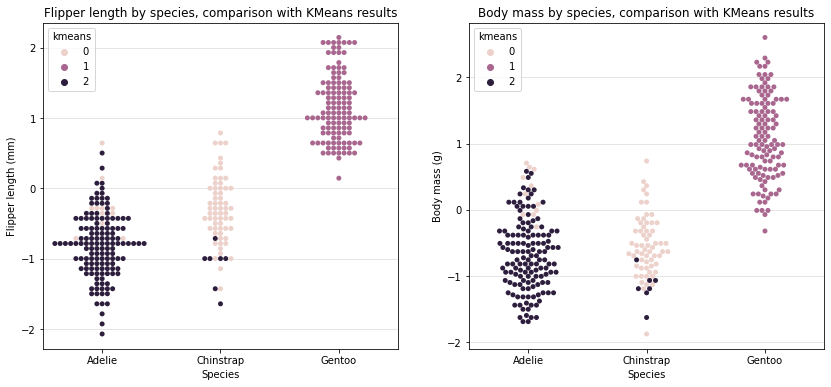

In [19]:
figure, axes = plt.subplots(1, 2, sharex=True, figsize=(14, 6))

sns.swarmplot(data=df_scaled, 
              x="species", 
              y="flipper_length_mm", 
              hue="kmeans", 
              legend=True,
              ax = axes[0]);

axes[0].set_title('Flipper length by species, comparison with KMeans results')
axes[0].set_xlabel('Species')
axes[0].set_ylabel('Flipper length (mm)')

sns.swarmplot(data=df_scaled, 
              x="species", 
              y="body_mass_g", 
              hue="kmeans", 
              legend=True,
              ax = axes[1]);

axes[1].set_title('Body mass by species, comparison with KMeans results')
axes[1].set_xlabel('Species')
axes[1].set_ylabel('Body mass (g)')

# Add horizontal gridlines
for ax in axes:
    ax.grid(axis='y', linestyle='-', alpha=0.4)

# Classification

Let's see if we can predict what island these samples are from

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled[float_cols], df_scaled['island'], test_size=0.33, random_state=42)

In [21]:
y_test.nunique()

3

In [22]:
svc_model = SVC()

In [23]:
svc_model.fit(X_train, y_train)

SVC()

In [24]:
preds = svc_model.predict(X_test)

In [25]:
print('balanced accuracy score:', '{:.2%}'.format(balanced_accuracy_score(y_test, preds)))
print('F1 weighted score:', '{:.2}'.format(f1_score(y_test, preds, average='weighted')))

balanced accuracy score: 57.47%
F1 weighted score: 0.65


# Regression

In [26]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(df_scaled[['bill_length_mm','bill_depth_mm', 'flipper_length_mm']], 
                                                        df_scaled['body_mass_g'], 
                                                        test_size=0.33, 
                                                        random_state=42)

In [27]:
knn = KNeighborsRegressor(3)

In [28]:
predictions = knn.fit(X_trainR, y_trainR).predict(X_testR)

Can make some plots to compare prediuctions vs test dataset:

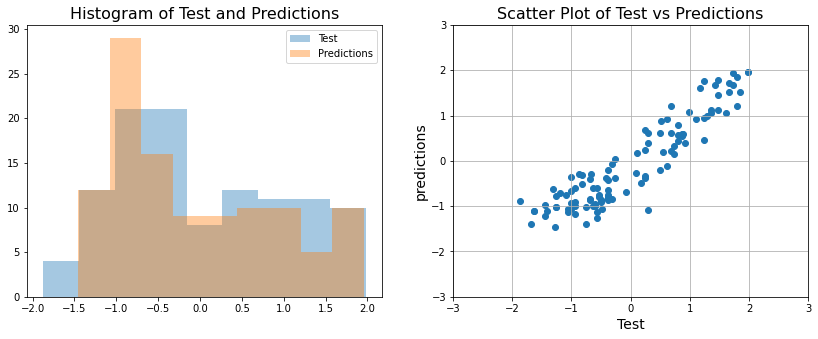

In [29]:
# define the size of the figure and create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# subplot 1
bin_no = 9 #number of bins in the histogram
a = 0.4

axs[0].hist(y_testR, bins=bin_no, alpha=a, label='Test')
axs[0].hist(predictions, bins=bin_no, alpha=a, label='Predictions')
axs[0].legend()

# subplot 2
axs[1].scatter(y_testR, predictions)
axs[1].set_xlabel('Test', fontsize=14)
axs[1].set_ylabel('predictions', fontsize=14)
axs[1].set_xlim([-3, 3])
axs[1].set_ylim([-3, 3])
axs[1].grid()

# add titles to the subplots
axs[0].set_title('Histogram of Test and Predictions', size = 16)
axs[1].set_title('Scatter Plot of Test vs Predictions', size=16)

# display the plots
plt.show()

In [30]:
# Calculate RMSE
rmse = mean_squared_error(y_testR, predictions, squared=False)
print("RMSE: {:.2f}".format(rmse))

# Calculate Explained Variance Score
evs = explained_variance_score(y_testR, predictions)
print("Explained Variance Score: {:.2f}".format(evs))

# Calculate R-squared
r2 = r2_score(y_testR, predictions)
print("R-squared: {:.2f}".format(r2))

RMSE: 0.41
Explained Variance Score: 0.84
R-squared: 0.84


## The End!